# 오토인코더 lstm 전이학습

---

`-` import 

In [53]:
import numpy as np
import pandas as pd
from datasetsforecast.m4 import M4, M4Evaluation
import matplotlib.pyplot as plt
import time
from keras.layers import *
from keras.models import Sequential ,Model
from keras.callbacks import EarlyStopping
import keras.backend as K

`-` data set

In [3]:
df,*_= M4.load(directory='data',group = 'Hourly')

lst = list(set(df.loc[:,'unique_id']))

tt = [df[df.loc[:,'unique_id']==lst[i]].iloc[:,1:4].set_index(['ds']) 
      for i in range(len(lst))]

for l in range(len(tt)):
    for s in range(1, 25):
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        tt[l]['shift_{}'.format(s)] = tt[l]['y'].shift(s)
        
tt=[tt[i].dropna(axis=0) for i in range(len(tt))]

train = np.concatenate([np.array(tt[i].iloc[:,1:]) for i in range(len(tt))])
y = np.concatenate([np.array(tt[i].iloc[:,0]) for i in range(len(tt))]).reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler1 = MinMaxScaler()

X_scale = min_max_scaler1.fit_transform(train)
y_scale = min_max_scaler1.fit_transform(y)

In [16]:
df = pd.read_csv('C:/Users/default.DESKTOP-2ISHQBS/Documents/R/time_ele/train.csv')

arr = df.iloc[:,9] # 전력소비량
date=  pd.to_datetime(df.iloc[:,2]) # 일시

df_= pd.DataFrame({'date':date,
              'ele': arr})

df_ = df_.set_index('date')

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

df_['mmele'] = min_max_scaler.fit_transform(df_.iloc[:].to_numpy().reshape(-1,1))

df_ = df_.drop(['ele'],axis=1)

for s in range(1, 25):
    df_['shift_{}'.format(s)] = df_['mmele'].shift(s)
    df_['shift_{}'.format(s)] = df_['mmele'].shift(s)

df_ = df_.dropna()

y = df_.iloc[:,[0]].values #scaled 

X = df_.iloc[:,1:]

from sklearn.model_selection import train_test_split

x_train,x_test, y_train , y_test = train_test_split(X.iloc[-2400:,:],y[-2400:],shuffle=False, test_size=0.1)

---

# 오토인코더 lstm pretrained model

In [64]:
automodel = Sequential()

K.clear_session()
automodel.add(LSTM(64,input_shape=(24,1),return_sequences=True))
automodel.add(LSTM(32,return_sequences=False))
automodel.add(RepeatVector(24))
automodel.add(LSTM(32,return_sequences=True))
automodel.add(LSTM(64,input_shape=(24,1),return_sequences=True))
automodel.add(TimeDistributed(Dense(1)))
automodel.compile(optimizer='adam', loss='mse')
automodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 32)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 24, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 24, 64)            24832     
                                                                 
 time_distributed (TimeDist  (None, 24, 1)             65        
 ributed)                                             

In [65]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

automodel.fit(X_scale,y_scale, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
2840/2840 [==============================] - 72s 24ms/step - loss: 9.2669e-05
Epoch 2/100
2840/2840 [==============================] - 69s 24ms/step - loss: 1.4031e-05
Epoch 3/100
2840/2840 [==============================] - 69s 24ms/step - loss: 1.1972e-05
Epoch 4/100
2840/2840 [==============================] - 68s 24ms/step - loss: 9.7325e-06
Epoch 5/100
2840/2840 [==============================] - 69s 24ms/step - loss: 8.6826e-06
Epoch 6/100
2840/2840 [==============================] - 71s 25ms/step - loss: 8.9413e-06
Epoch 6: early stopping


# transfer learning

In [66]:
pretrained_layers = automodel.layers[:-1]
for layer in automodel.layers:
    layer.trainable = True # freezing
    
K.clear_session()
model012 = Sequential(pretrained_layers)
model012.add(LSTM(64, name='lstm_t',input_shape=(24,64)))
model012.add(Dense(1))
model012.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=0)
start_time22 = time.time()
model012.fit(x_train, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])
end_time22 = time.time()

Epoch 1/100
2160/2160 [==============================] - 33s 13ms/step - loss: 4.5200e-05
Epoch 2/100
2160/2160 [==============================] - 29s 13ms/step - loss: 2.2819e-05
Epoch 3/100
2160/2160 [==============================] - 29s 13ms/step - loss: 2.0939e-05
Epoch 4/100
2160/2160 [==============================] - 29s 13ms/step - loss: 1.9764e-05
Epoch 5/100
2160/2160 [==============================] - 29s 13ms/step - loss: 1.8037e-05
Epoch 6/100
2160/2160 [==============================] - 29s 13ms/step - loss: 1.6563e-05
Epoch 7/100
2160/2160 [==============================] - 29s 13ms/step - loss: 1.6461e-05
Epoch 8/100
2160/2160 [==============================] - 29s 13ms/step - loss: 1.5489e-05
Epoch 9/100
2160/2160 [==============================] - 29s 13ms/step - loss: 1.5914e-05


---

# 비교군 

- autoencoder non pretrained model
- 기존 non-pretrained 방법
- 기존 pretrained 방법

---

###  autoencoder non pretrained model

In [113]:
automodel1 = Sequential()

K.clear_session()
automodel1.add(LSTM(64,input_shape=(24,1),return_sequences=True))
automodel1.add(LSTM(32,return_sequences=False))
automodel1.add(RepeatVector(24))
automodel1.add(LSTM(32,return_sequences=True))
automodel1.add(LSTM(64,input_shape=(24,1),return_sequences=False))
automodel1.add((Dense(1)))
automodel1.compile(optimizer='adam', loss='mse')
automodel1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 32)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 24, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [114]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

automodel1.fit(x_train,y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
2160/2160 [==============================] - 28s 11ms/step - loss: 1.1583e-04
Epoch 2/100
2160/2160 [==============================] - 23s 11ms/step - loss: 2.9984e-05
Epoch 3/100
2160/2160 [==============================] - 23s 11ms/step - loss: 2.1880e-05
Epoch 4/100
2160/2160 [==============================] - 23s 11ms/step - loss: 1.9261e-05
Epoch 5/100
2160/2160 [==============================] - 23s 11ms/step - loss: 1.6977e-05
Epoch 6/100
2160/2160 [==============================] - 23s 11ms/step - loss: 1.5505e-05
Epoch 7/100
2160/2160 [==============================] - 23s 11ms/step - loss: 1.6692e-05
Epoch 7: early stopping


---

### 기존 non-pretrained 방법

In [122]:
K.clear_session()
modelnon0 = Sequential() # Sequeatial Model
modelnon0.add(LSTM(64, return_sequences=True,input_shape=(24, 1)))# (timestep, feature)
modelnon0.add(LSTM(32))
modelnon0.add(Dense(1)) # output = 1
modelnon0.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
start_timenon0 = time.time()
modelnon0.fit(x_train,y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])
end_timenon0 = time.time()

Epoch 1/100
2160/2160 [==============================] - 14s 5ms/step - loss: 5.3170e-05
Epoch 2/100
2160/2160 [==============================] - 12s 5ms/step - loss: 2.3713e-05
Epoch 3/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.9659e-05
Epoch 4/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.8894e-05
Epoch 5/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.8055e-05
Epoch 6/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.7648e-05
Epoch 7/100
2160/2160 [==============================] - 12s 5ms/step - loss: 1.8185e-05
Epoch 7: early stopping


---

### 기존 pretrained 방법

In [91]:
K.clear_session()
model01 = Sequential() # Sequeatial Model
model01.add(LSTM(64,name ='lstm0', return_sequences=True, input_shape=(24, 1))) # (timestep, feature)
model01.add(LSTM(32, return_sequences=True)) # 연결한 모델의 차원을 맞추기 위해 시퀀스 반환을 함
model01.add(Dense(1)) # output 사용 x
model01.compile(loss='mean_squared_error', optimizer='adam')
np.random.seed(1)
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model01.fit(X_scale, y_scale, epochs=100,
          batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
2840/2840 [==============================] - 36s 12ms/step - loss: 1.5185e-04
Epoch 2/100
2840/2840 [==============================] - 35s 12ms/step - loss: 1.6656e-05
Epoch 3/100
2840/2840 [==============================] - 34s 12ms/step - loss: 9.5554e-06
Epoch 4/100
2840/2840 [==============================] - 34s 12ms/step - loss: 6.2406e-06
Epoch 5/100
2840/2840 [==============================] - 34s 12ms/step - loss: 5.1281e-06
Epoch 6/100
2840/2840 [==============================] - 34s 12ms/step - loss: 4.9113e-06
Epoch 7/100
2840/2840 [==============================] - 35s 12ms/step - loss: 3.7298e-06
Epoch 8/100
2840/2840 [==============================] - 36s 13ms/step - loss: 3.4296e-06
Epoch 9/100
2840/2840 [==============================] - 36s 13ms/step - loss: 3.0742e-06
Epoch 10/100
2840/2840 [==============================] - 36s 13ms/step - loss: 3.3453e-06
Epoch 10: early stopping


In [92]:
pretrained_layers = model01.layers[:-1]
for layer in model01.layers:
    layer.trainable = True # freezing
    

model011 = Sequential(pretrained_layers)
model011.add(LSTM(64, input_shape=(24,64)))
model011.add(Dense(1))
model011.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=0)
start_time22 = time.time()
model011.fit(x_train, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])
end_time22 = time.time()

Epoch 1/100
2160/2160 [==============================] - 20s 8ms/step - loss: 4.0714e-05
Epoch 2/100
2160/2160 [==============================] - 17s 8ms/step - loss: 1.9990e-05
Epoch 3/100
2160/2160 [==============================] - 17s 8ms/step - loss: 1.8598e-05
Epoch 4/100
2160/2160 [==============================] - 17s 8ms/step - loss: 1.5589e-05
Epoch 5/100
2160/2160 [==============================] - 17s 8ms/step - loss: 1.6602e-05


---

# test

In [123]:
pred1 = modelnon0.predict(x_test)
pred2 = automodel1.predict(x_test)
pred3 = model011.predict(x_test)
pred4 = model012.predict(x_test)

8/8 [==============================] - 0s 6ms/step


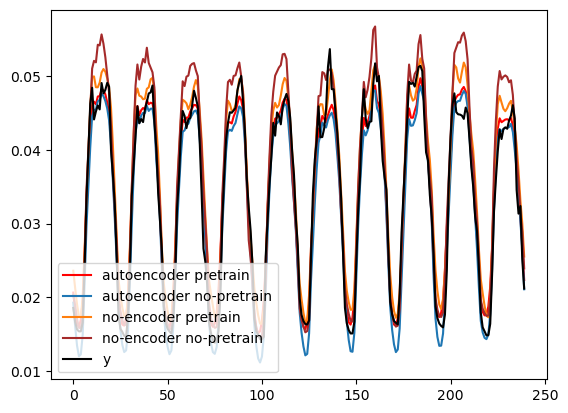

In [125]:
plt.plot(pred4,label = 'autoencoder pretrain',color = 'red')
plt.plot(pred2.flatten(),label = 'autoencoder no-pretrain')
plt.plot(pred3,label = 'no-encoder pretrain')
plt.plot(pred1,label = 'no-encoder no-pretrain',color='brown')
plt.plot(y_test,label = 'y', color = 'black')
plt.legend(loc='lower left')
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
msepred1= mean_squared_error(y_test, pred1)
maepred1= mean_absolute_error(y_test, pred1)
msepred2= mean_squared_error(y_test, pred2)
maepred2= mean_absolute_error(y_test, pred2)
mse2= mean_squared_error(y_test, pred3)
mae2= mean_absolute_error(y_test, pred3)
mse3= mean_squared_error(y_test, pred4)
mae3= mean_absolute_error(y_test, pred4)


print('no-encoder no-pretrain',f"MSE : {msepred1:.8f}",f"MAE : {maepred1:.8f}")
print('no-encoder pretrain ',f"MSE : {mse2:.8f}",f"MAE : {mae2:.8f}")
print('autoencoder no-pretrain',f"MSE : {msepred2:.8f}",f"MAE : {maepred2:.8f}")
print('autoencoder pretrain',f"MSE : {mse3:.8f}",f"MAE : {mae3:.8f}")

no-encoder no-pretrain MSE : 0.00001696 MAE : 0.00322499
no-encoder pretrain  MSE : 0.00001056 MAE : 0.00273292
autoencoder no-pretrain MSE : 0.00000720 MAE : 0.00216013
autoencoder pretrain MSE : 0.00000537 MAE : 0.00187278
